In [20]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic, HI_VAE_functions
import time
import pandas as pd
import warnings
from lifelines import CoxPHFitter
from tableone import TableOne
warnings.filterwarnings("ignore")

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.compare import compare_survival
from sksurv.nonparametric import kaplan_meier_estimator

from sksurv.util import Surv

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%matplotlib inline

### Experiment setting

In [22]:
dataset_name = "gbsg2_test_encoding"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "./dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

In [23]:
gbsg2_control = pd.read_csv(data_file_control,header=None)
gbsg2_control.columns = ['time','censoring','age','ER','menostat','pnodes','PR','tgrade','tsize']

In [24]:
gbsg2_control_columns = pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
gbsg2_control_columns.insert(0, 'censor')
gbsg2_control_columns.insert(0, 'time')

### Data loading and Feature analysis treated/control

In [25]:
# Load training data
data_control, feat_types_dict, miss_mask_control, true_miss_mask_control, n_samples_control = data_processing.read_data(data_file_control, 
                                                                                                                        feat_types_file_control, 
                                                                                                                        miss_file, true_miss_file)
# Feature analysis
data_transformed_control = data_processing.discrete_variables_transformation(data_control, feat_types_dict)


In [26]:
# Load training data
data_treated, feat_types_dict, miss_mask_treated, true_miss_mask_treated, n_samples_treated = data_processing.read_data(data_file_treated, 
                                                                                                                        feat_types_file_treated, 
                                                                                                                        miss_file, true_miss_file)

# Feature analysis
data_transformed_treated = data_processing.discrete_variables_transformation(data_treated, feat_types_dict)


In [27]:
df_transformed_treated = pd.DataFrame(data_transformed_treated.numpy(), columns=gbsg2_control_columns)
df_transformed_control = pd.DataFrame(data_transformed_control.numpy(), columns=gbsg2_control_columns)
df_transformed_treated["treatment"]=1
df_transformed_control["treatment"]=0
df_transformed_all = pd.concat([df_transformed_control, df_transformed_treated], ignore_index=True)

In [28]:
feat_types_dict_all = feat_types_dict.copy()#

comparison variable treatment 9


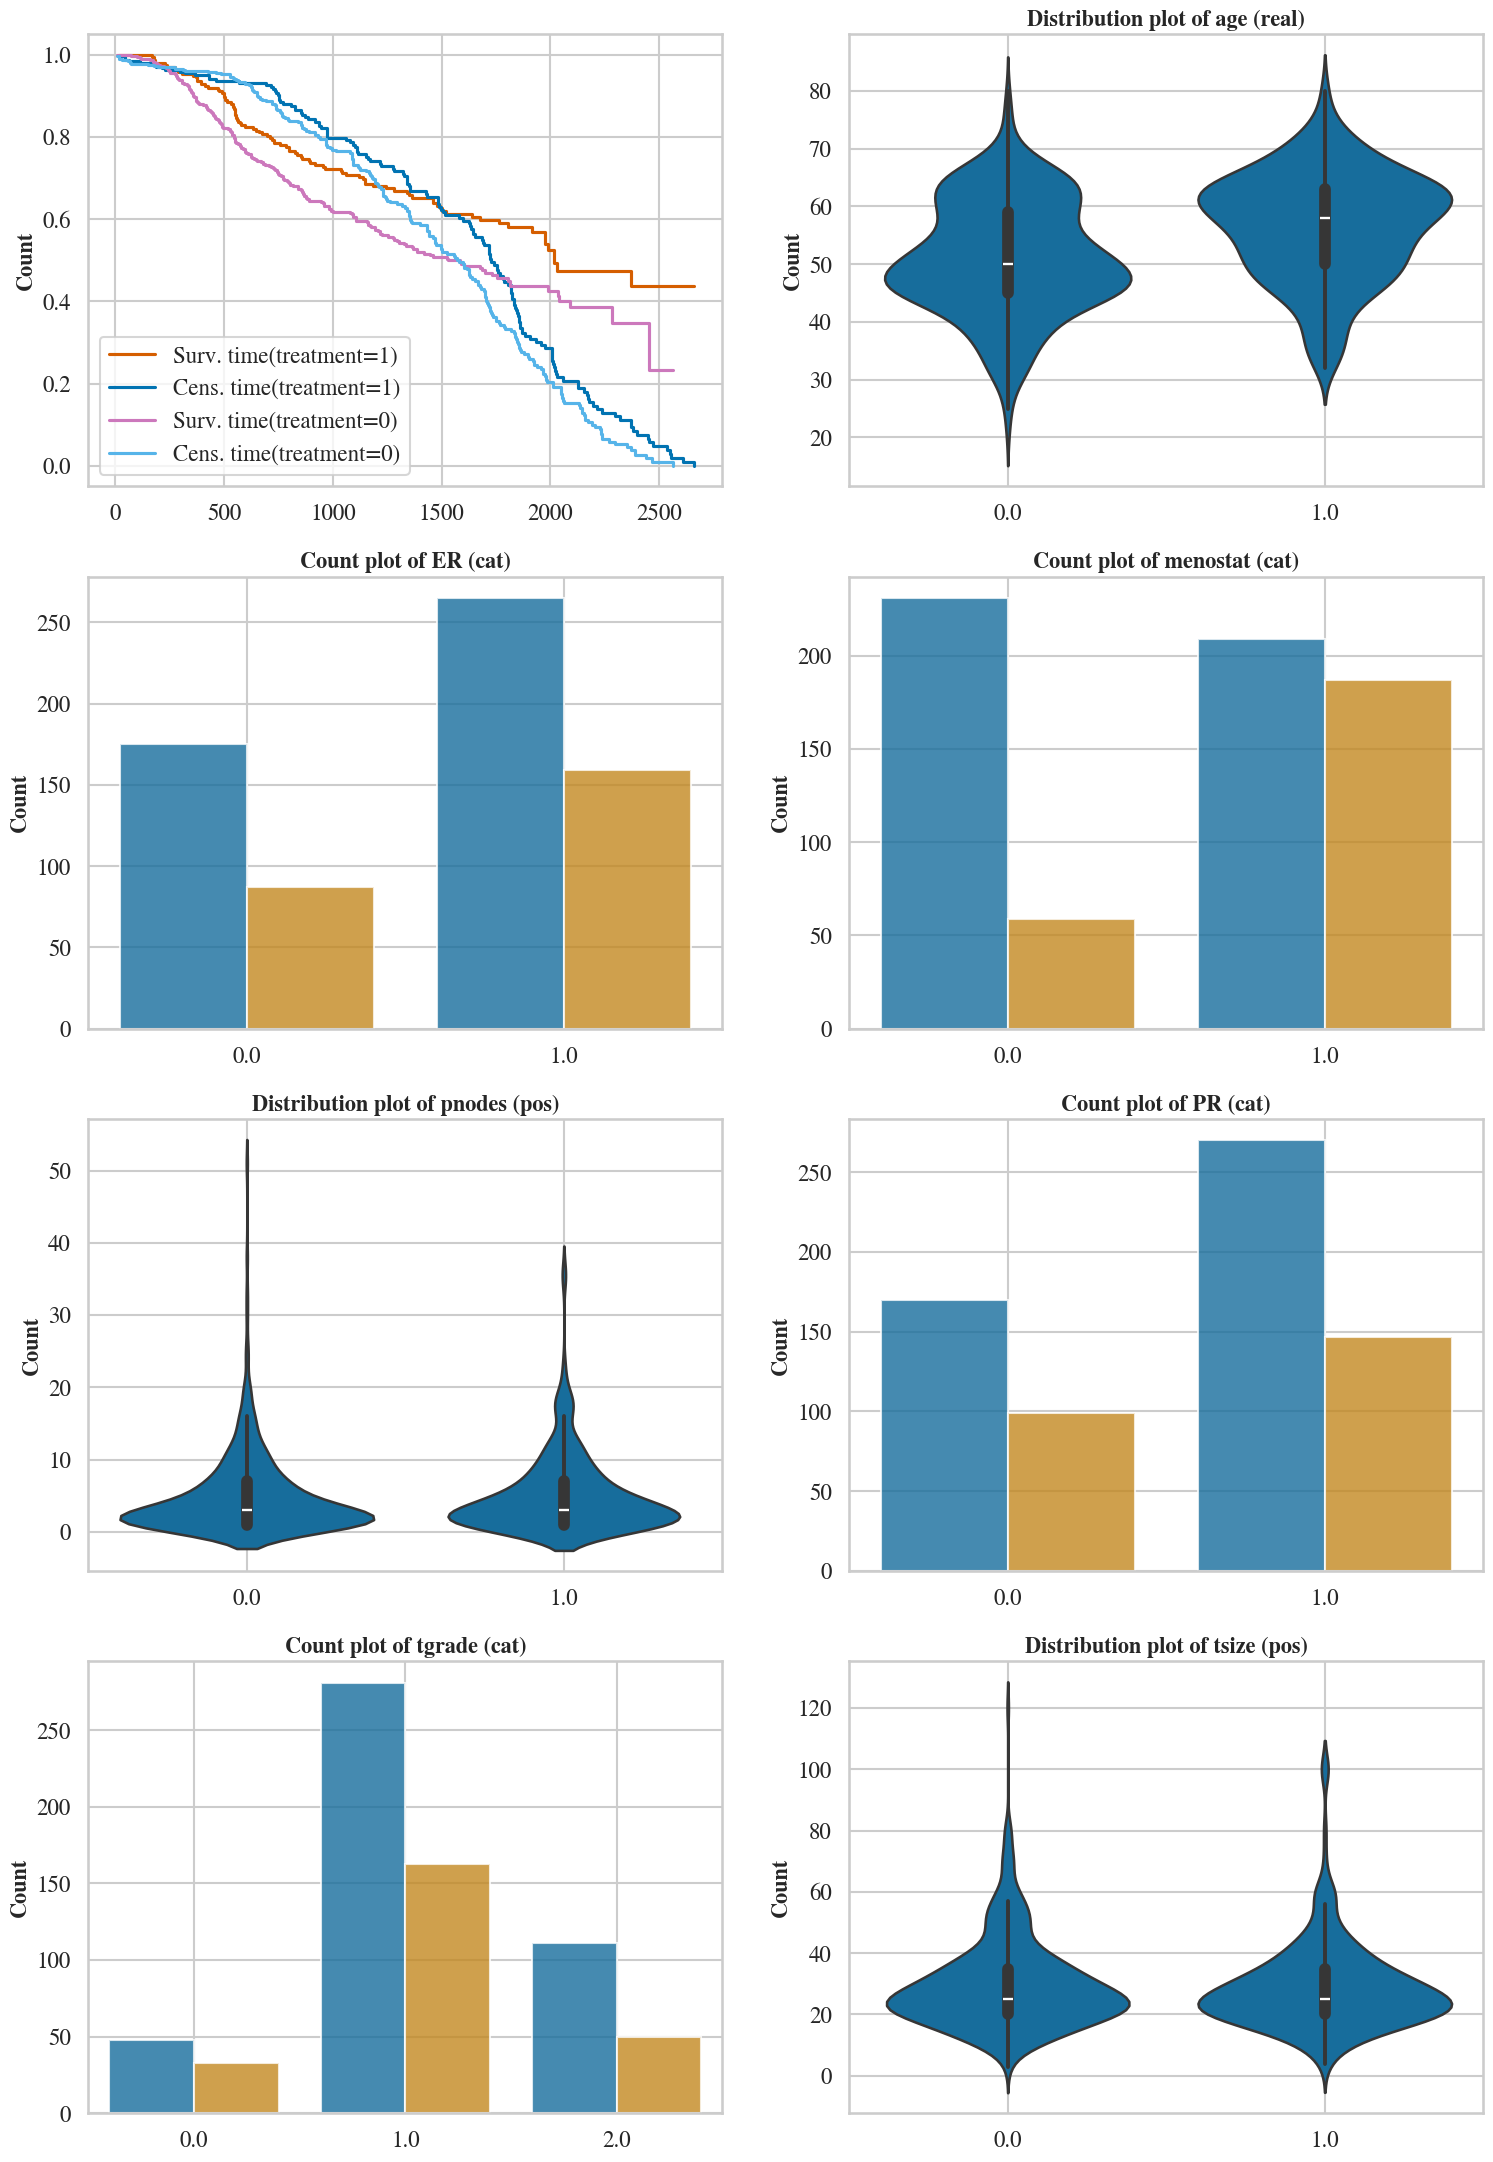

In [29]:
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_all.to_numpy(),feat_types_dict_all,feat_comparison_name = 'treatment')

In [32]:
categorical = ['censor','menostat', 'tgrade','treatment','PR','ER']
continuous = ['time', 'pnodes', 'tsize', 'age']
nonnormal = ['time', 'pnodes', 'tsize', 'age']

In [33]:
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                           Grouped by treatment                                                                            
                                        Missing                Overall                     0                      1 P-Value
n                                                                  686                   440                    246        
time, median [Q1,Q3]                          0  1084.0 [567.8,1684.8]  967.0 [547.8,1573.0]  1220.5 [695.8,1818.0]   0.001
censor, n (%)          0.0                                  387 (56.4)            235 (53.4)             152 (61.8)   0.041
                       1.0                                  299 (43.6)            205 (46.6)              94 (38.2)        
age, median [Q1,Q3]                           0       53.0 [46.0,61.0]      50.0 [45.0,59.0]       58.0 [50.0,63.0]  <0.001
ER, n (%)              0.0                                  262 (38.2)            175 (39.8)              87 (35.4)   0.290
        

## Training VAE

### Experiment setting

Epoch: [ 0]  time: 0.0791, ELBO_train: -16.15649573, KL_z: 1.42316190, KL_s: 0.09580215, reconstruction loss: -14.63753168
Epoch: [100]  time: 2.8863, ELBO_train: -13.78413423, KL_z: 0.59360582, KL_s: 0.03381006, reconstruction loss: -13.15671835
Epoch: [200]  time: 5.6453, ELBO_train: -13.47762966, KL_z: 0.78402440, KL_s: 0.02602045, reconstruction loss: -12.66758482
Epoch: [300]  time: 8.1400, ELBO_train: -13.57760811, KL_z: 0.90614410, KL_s: 0.02483606, reconstruction loss: -12.64662794
Epoch: [400]  time: 10.6957, ELBO_train: -13.52173646, KL_z: 1.01145625, KL_s: 0.02491681, reconstruction loss: -12.48536340
Epoch: [500]  time: 13.4017, ELBO_train: -13.52768485, KL_z: 1.09380953, KL_s: 0.02689107, reconstruction loss: -12.40698425
Epoch: [600]  time: 15.9519, ELBO_train: -13.38148721, KL_z: 1.14890707, KL_s: 0.02815318, reconstruction loss: -12.20442696
Epoch: [700]  time: 18.5615, ELBO_train: -13.28777726, KL_z: 1.25367844, KL_s: 0.02883728, reconstruction loss: -12.00526154
Epoch

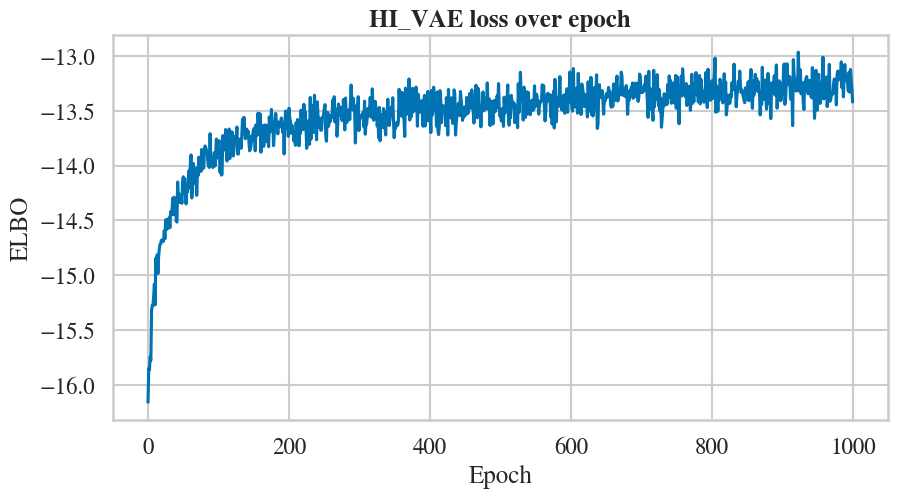

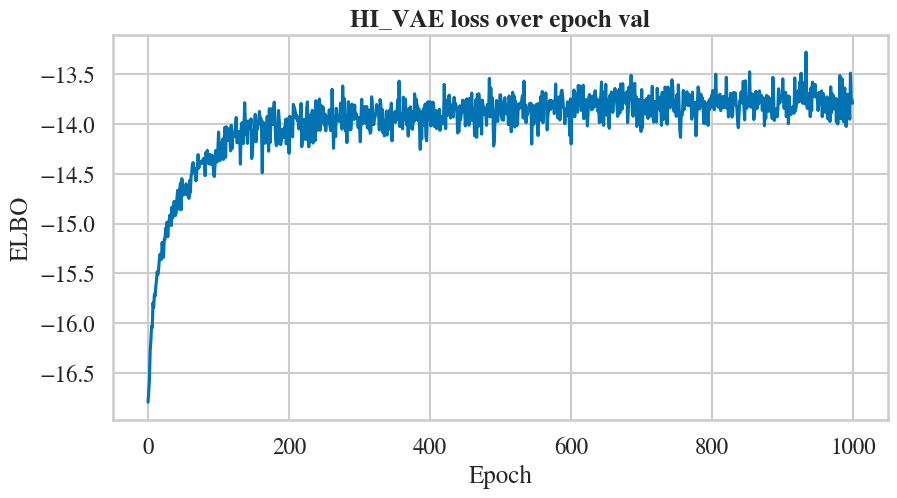

In [34]:

vae_model = HI_VAE_functions.HI_VAE_model(data = data_control, miss_mask = miss_mask_control, true_miss_mask = true_miss_mask_control, 
                                          feat_types_file = feat_types_file_control,feat_types_dict = feat_types_dict,
                                          dataset_name = dataset_name, m_perc = m_perc, mask = mask, train_test_share = .9, 
                                          batch_size = 100, n_generated_sample = 10,model_name="HIVAE_inputDropout", dim_latent_z = 20,
                                          dim_latent_y = 15, dim_latent_s = 20, epochs = 1000, lr = 1e-3)


## Generated samples from control dataset

### Generate from original sample

In [35]:

est_data_gen_transformed = HI_VAE_functions.HI_VAE_generation(vae_model = vae_model, data_forgen = data_control, 
                                                              feat_types_dict = feat_types_dict, miss_mask_forgen = miss_mask_control,
                                                              true_miss_mask_forgen = true_miss_mask_control, n_batches_generation = 1, 
                                                              n_generated_sample = 100)


440


### Statistical analysis with simulated vs initial control data

In [36]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=gbsg2_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[3].numpy(), columns=gbsg2_control_columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_initial_generated = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

comparison variable sample 9


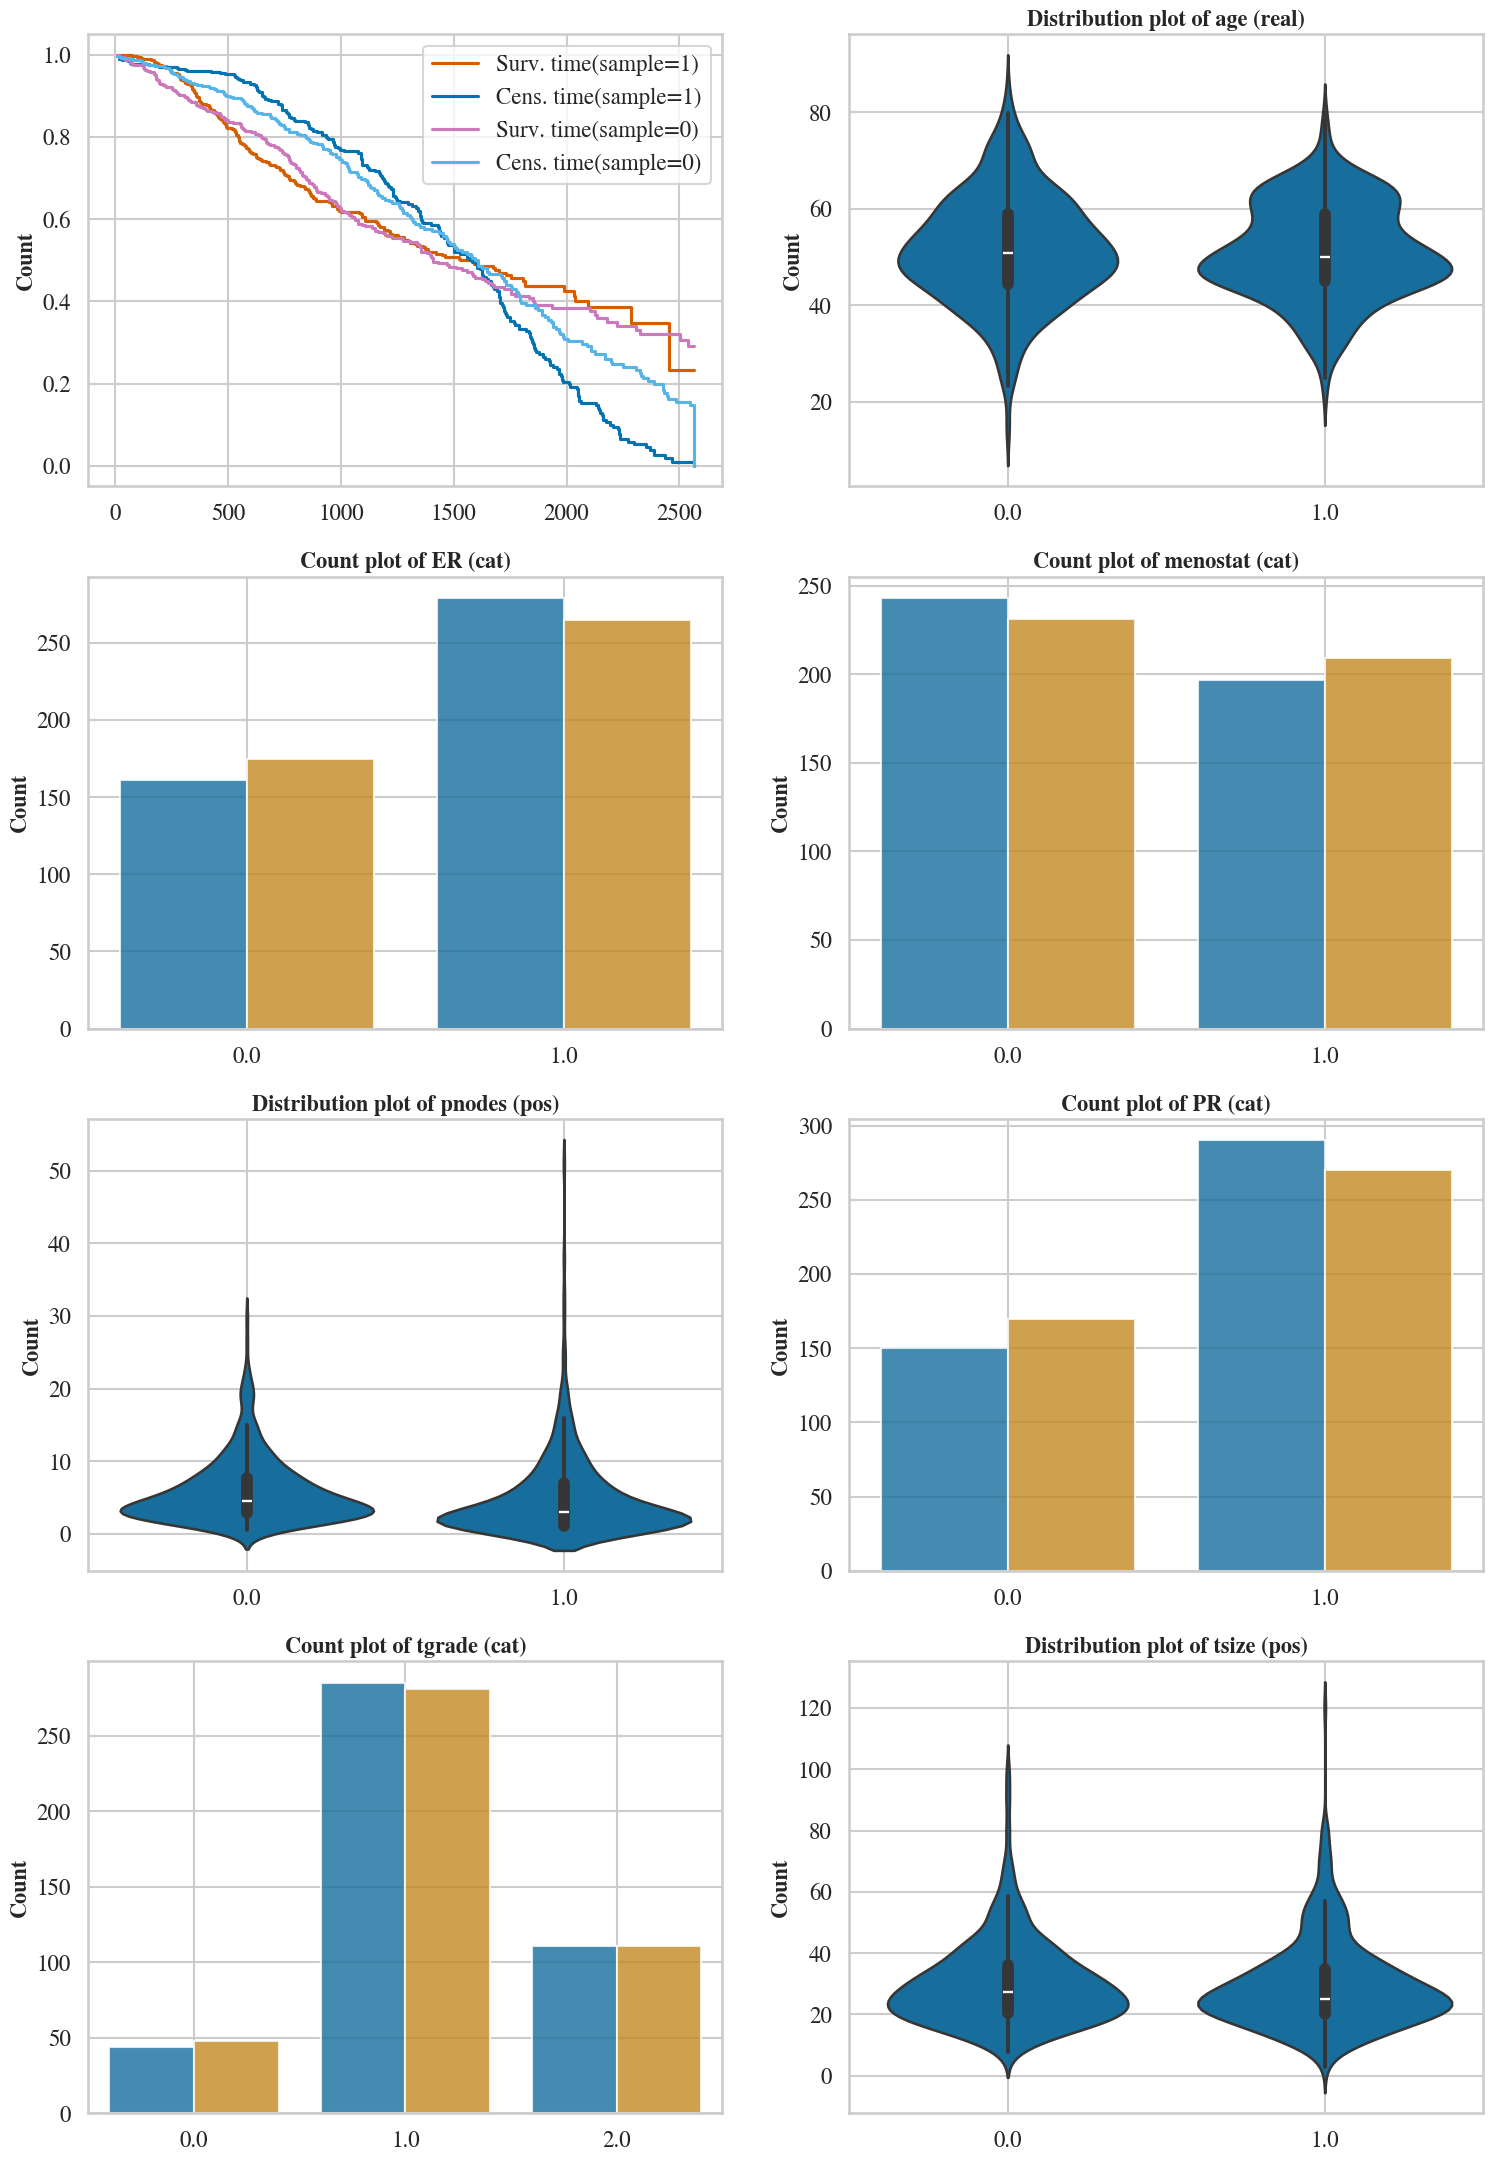

In [37]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_compare_data(df_transformed_initial_generated.to_numpy(),feat_types_dict_all,feat_comparison_name = 'sample')

In [39]:
# Table1 from initial control x generated control
categorical = ['censor','menostat', 'tgrade','PR','ER','sample']
table1 = TableOne(df_transformed_initial_generated, categorical=categorical, continuous=continuous, groupby='sample',nonnormal=nonnormal, pval=True)
print(table1)

                           Grouped by sample                                                                          
                                     Missing               Overall                     0                     1 P-Value
n                                                              880                   440                   440        
time, median [Q1,Q3]                       0  957.5 [545.8,1557.4]  947.2 [517.1,1536.3]  967.0 [547.8,1573.0]   0.705
censor, n (%)          0.0                              462 (52.5)            227 (51.6)            235 (53.4)   0.637
                       1.0                              418 (47.5)            213 (48.4)            205 (46.6)        
age, median [Q1,Q3]                        0      50.3 [44.8,59.0]      50.8 [44.4,59.0]      50.0 [45.0,59.0]   0.630
ER, n (%)              0.0                              336 (38.2)            161 (36.6)            175 (39.8)   0.367
                       1.0                      

### Statistical analysis: generated control x initial treated

In [450]:
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[2].numpy(), columns=gbsg2_control_columns)
df_transformed_generated['treatment'] = 0
df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
categorical = ['censor','menostat', 'tgrade','PR','ER','treatment']

In [451]:
# Table1 from initial control x initial treated
table1 = TableOne(df_transformed_all, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                            Grouped by treatment                                                                            
                                         Missing                Overall                     0                      1 P-Value
n                                                                   686                   440                    246        
time, median [Q1,Q3]                           0  1084.0 [567.8,1684.8]  967.0 [547.8,1573.0]  1220.5 [695.8,1818.0]   0.001
censor, n (%)           0.0                                  387 (56.4)            235 (53.4)             152 (61.8)   0.041
                        1.0                                  299 (43.6)            205 (46.6)              94 (38.2)        
age, median [Q1,Q3]                            0       53.0 [46.0,61.0]      50.0 [45.0,59.0]       58.0 [50.0,63.0]  <0.001
estrec, median [Q1,Q3]                         0       36.0 [8.0,114.0]       32.0 [8.0,92.2]       46.0 [9.0,182.5]   0.009


In [452]:
# Table1 from generated control x initial treated
table1 = TableOne(df_transformed_T_Cgen, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

                            Grouped by treatment                                                                             
                                         Missing                Overall                      0                      1 P-Value
n                                                                   686                    440                    246        
time, median [Q1,Q3]                           0  1060.5 [540.5,1645.0]  1001.1 [448.7,1508.9]  1220.5 [695.8,1818.0]  <0.001
censor, n (%)           0.0                                  391 (57.0)             239 (54.3)             152 (61.8)   0.070
                        1.0                                  295 (43.0)             201 (45.7)              94 (38.2)        
age, median [Q1,Q3]                            0       53.0 [45.1,61.0]       50.0 [42.6,58.1]       58.0 [50.0,63.0]  <0.001
estrec, median [Q1,Q3]                         0       29.2 [7.7,107.6]        24.5 [7.0,83.0]       46.0 [9.0,182.5] 

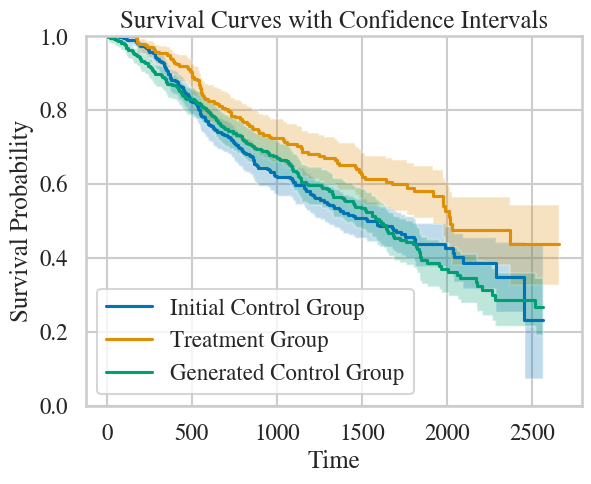

In [453]:

time_initial_C, survival_prob_initial_C, conf_int_initial_C = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_initial_T, survival_prob_initial_T, conf_int_initial_T = kaplan_meier_estimator(
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_all[df_transformed_all['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_C, survival_prob_T_Cgen_C, conf_int_T_Cgen_C = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==0].to_numpy()[:,0], conf_type="log-log"
)

time_T_Cgen_T, survival_prob_T_Cgen_T, conf_int_T_Cgen_T = kaplan_meier_estimator(
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,1]==1, 
    df_transformed_T_Cgen[df_transformed_T_Cgen['treatment']==1].to_numpy()[:,0], conf_type="log-log"
)


plt.step(time_initial_C, survival_prob_initial_C, where="post", label="Initial Control Group")
plt.fill_between(time_initial_C, conf_int_initial_C[0], conf_int_initial_C[1], alpha=0.25, step="post")

plt.step(time_initial_T, survival_prob_initial_T, where="post", label="Treatment Group")
plt.fill_between(time_initial_T, conf_int_initial_T[0], conf_int_initial_T[1], alpha=0.25, step="post")


plt.step(time_T_Cgen_C, survival_prob_T_Cgen_C, where="post", label="Generated Control Group")
plt.fill_between(time_T_Cgen_C, conf_int_T_Cgen_C[0], conf_int_T_Cgen_C[1], alpha=0.25, step="post")


#plt.step(time_T_Cgen_T, survival_prob_T_Cgen_T, where="post")
#plt.fill_between(time_T_Cgen_T, conf_int_T_Cgen_T[0], conf_int_T_Cgen_T[1], alpha=0.25, step="post")

plt.ylim(0, 1)

# Add legend
plt.legend()

# Optional: add axis labels and title
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Survival Curves with Confidence Intervals")

# Show the plot
plt.show()

## Tests

In [454]:
categorical_encode = ['censor','menostat', 'tgrade','PR','ER','treatment']

In [455]:
df_transformed_all_oh = df_transformed_all.copy()
for feat in categorical_encode:
    df_transformed_all_oh = data_processing.encode_and_bind(df_transformed_all_oh,feat)
X_initial = df_transformed_all_oh.to_numpy()[:,2:15]
Y_initial = Surv.from_arrays(df_transformed_all_oh.to_numpy()[:,1]==1,df_transformed_all_oh.to_numpy()[:,0])    

In [456]:
number_column_treatment = 8 # in X_initial

In [457]:
cox_initial = CoxPHSurvivalAnalysis()
cox_initial.fit(X_initial,Y_initial)
cox_initial.coef_

array([-9.45340713e-03,  1.97817754e-04,  2.58156545e-01,  4.87818043e-02,
       -2.21749417e-03,  7.79832903e-03, -3.46241621e-01,  6.35978663e-01,
        7.79350191e-01])

In [458]:
coef_treat = np.zeros((est_data_gen_transformed.shape[0],cox_initial.coef_.shape[0] + 1))
for i in np.arange(est_data_gen_transformed.shape[0]):
    #print(i)
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=gbsg2_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = data_processing.encode_and_bind(df_transformed_T_Cgen_oh,feat)
    
    X_T_Cgen = df_transformed_T_Cgen_oh.to_numpy()[:,2:15]
    Y_T_Cgen = Surv.from_arrays(df_transformed_T_Cgen_oh.to_numpy()[:,1]==1,df_transformed_T_Cgen_oh.to_numpy()[:,0])
    coef_treat[i,0] = -np.log(compare_survival(Y_T_Cgen,X_T_Cgen[:,number_column_treatment])[1])
    cox_generated = CoxPHSurvivalAnalysis()
    cox_generated.fit(X_T_Cgen,Y_T_Cgen)
    coef_treat[i,1:] = cox_generated.coef_[:]


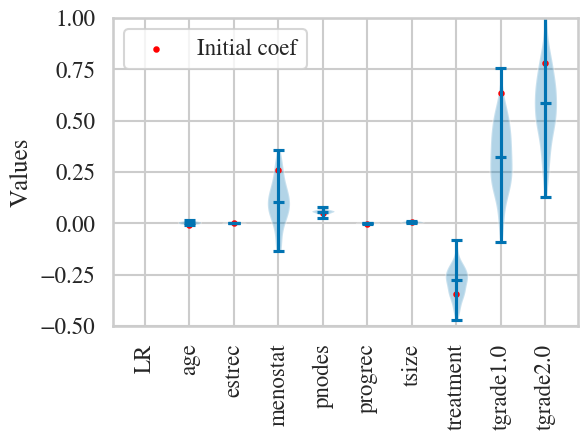

In [459]:
# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1+np.arange(coef_treat.shape[1])  # X-axis positions of violins
y_values = np.zeros(coef_treat.shape[1])
y_values[0] = -np.log(compare_survival(Y_initial,X_initial[:,number_column_treatment])[1])
y_values[1:] = cox_initial.coef_[:]  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(1+np.arange(coef_treat.shape[1]))
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels(['LR','age', 'ER', 'menostat', 'pnodes', 'PR', 'tsize', 'treatment', 'tgrade1.0', 'tgrade2.0'])
ax.set_ylabel("Values")
ax.set_ylim(-0.5, 1) #to zoom on treatment values
ax.legend()

plt.show()

### Log rank test

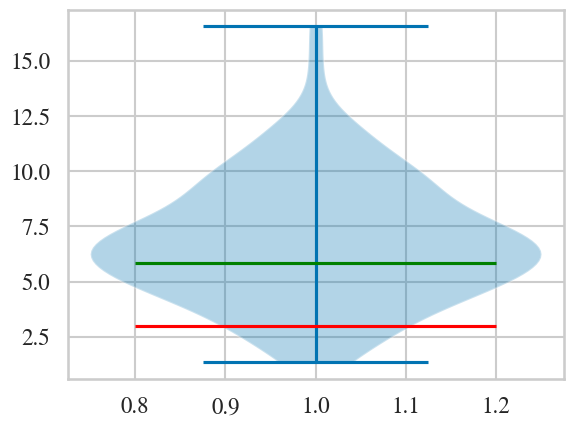

In [460]:
plt.violinplot(coef_treat[:,0])#,
plt.hlines(y_values[0],0.8,1.2,color='green')
plt.hlines(-np.log(0.05),0.8,1.2,color='red')

### Test coefficient traitement (Cox)

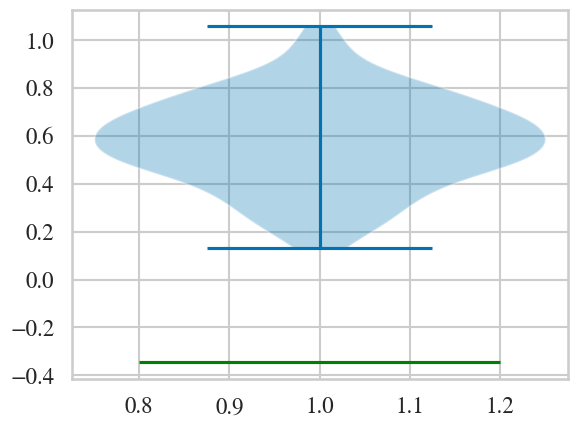

In [461]:
plt.violinplot(coef_treat[:,number_column_treatment+1])#,
plt.hlines(y_values[7],0.8,1.2,color='green')

In [464]:
# Fit the Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(df_transformed_all_oh, duration_col='time', event_col='censor')

# Display summary statistics of the model
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
             duration col = 'time'
                event col = 'censor'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 299
   partial log-likelihood = -1735.73
         time fit was run = 2025-04-14 13:42:13 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
estrec     0.00      1.00      0.00           -0.00            0.00                1.00                1.00
menostat   0.26      1.29      0.18           -0.10            0.62                0.90                1.86
pnodes     0.05      1.05      0.01            0.03            0.06                1.03                1.07
progrec   -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
tsize      0.01      1.01      0.00            0.00            0.02                1.00                1.02
treatment -0.35      0.71      0.13           -0.60           -0.09                0.55                0.91
tgrade1.0  0.64      1.89      0.25            0.15            1.12                1.16                3.08
tgrade2.0  0.78      2.18      0.27            0.25            1.31                1.29                3.69

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 -1.02   0.31      1.69
estrec       0.00  0.44   0.66      0.60
menostat     0.00  1.41   0.16      2.65
pnodes       0.00  6.55 <0.005     34.03
progrec      0.00 -3.87 <0.005     13.14
tsize        0.00  1.98   0.05      4.39
treatment    0.00 -2.68   0.01      7.10
tgrade1.0    0.00  2.55   0.01      6.55
tgrade2.0    0.00  2.90 <0.005      8.08
---
Concordance = 0.69
Partial AIC = 3489.46
log-likelihood ratio test = 104.75 on 9 df
-log2(p) of ll-ratio test = 59.01

In [465]:
for i in np.arange(est_data_gen_transformed.shape[0]):
    df_transformed_generated = pd.DataFrame(est_data_gen_transformed[i].numpy(), columns=gbsg2_control_columns)
    df_transformed_generated['treatment'] = 0
    df_transformed_T_Cgen = pd.concat([df_transformed_treated, df_transformed_generated], ignore_index=True)
    df_transformed_T_Cgen_oh = df_transformed_T_Cgen.copy()
    for feat in categorical_encode:
        df_transformed_T_Cgen_oh = encode_and_bind(df_transformed_T_Cgen_oh,feat)
    cph_g = CoxPHFitter()
    cph_g.fit(df_transformed_T_Cgen_oh, duration_col='time', event_col='censor')

    # Display summary statistics of the model
    print(cph_g.print_summary())
    

NameError: name 'encode_and_bind' is not defined

In [466]:
df_transformed_T_Cgen

,time,censor,age,estrec,menostat,pnodes,progrec,tgrade,tsize,treatment
0,2018.000000,1.0,56.000000,77.000000,1.0,7.000000,61.000000,1.0,12.000000,1
1,712.000000,1.0,58.000000,271.000000,1.0,9.000000,52.000000,1.0,35.000000,1
2,1807.000000,1.0,59.000000,29.000000,1.0,4.000000,60.000000,1.0,17.000000,1
3,2172.000000,0.0,59.000000,0.000000,1.0,2.000000,181.000000,1.0,8.000000,1
4,577.000000,1.0,68.000000,20.000000,1.0,9.000000,16.000000,1.0,40.000000,1
...,...,...,...,...,...,...,...,...,...,...
681,1499.617188,0.0,53.755650,337.755859,0.0,4.475043,117.853134,2.0,31.603106,0
682,664.711792,0.0,64.846558,11.422462,0.0,4.118942,2.898287,2.0,19.140852,0
683,883.102539,1.0,50.476204,1.415730,0.0,4.408020,46.910557,0.0,25.748217,0
684,2016.052368,1.0,57.817070,178.153381,1.0,1.220410,53.085842,2.0,27.616489,0


In [ ]:
#df_transformed_all.columns


In [ ]:
cox_initial = CoxPHSurvivalAnalysis()
cox_initial.fit(X_initial,Y_initial)
cox_initial.coef_

In [ ]:
df_transformed_T_Cgen.head()

In [ ]:
df_transformed_T_Cgen.head()

In [ ]:
print(compare_survival(Y_T_Cgen,X_T_Cgen[:,-1]))

In [ ]:
df_transformed_all[df_transformed_all['treatment']==0].head()

In [ ]:
categorical = ['censor','strat2', 'sex', 'raceth', 'ivdrug', 'karnof','treatment']
continuous = ['time', 'cd4',   'priorzdv', 'age']
nonnormal = ['time', 'cd4',   'priorzdv']
table1 = TableOne(df_transformed_T_Cgen, categorical=categorical, continuous=continuous, groupby='treatment',nonnormal=nonnormal, pval=True)
print(table1)

In [ ]:
print(compare_survival(Y_gen,X_gen[:,0]))

In [ ]:
cox_T_Cgen = CoxPHSurvivalAnalysis()
cox_T_Cgen.fit(X_T_Cgen,Y_T_Cgen)
cox_T_Cgen.coef_

In [ ]:
df_transformed_initial = pd.DataFrame(data_transformed_control.numpy(), columns=aids_control_columns)
df_transformed_generated = pd.DataFrame(est_data_gen_transformed[0].numpy(), columns=aids_control_columns)
df_transformed_initial["sample"]=1
df_transformed_generated["sample"]=0
df_transformed_all = pd.concat([df_transformed_initial, df_transformed_generated], ignore_index=True)

In [ ]:
cox_gen = CoxPHSurvivalAnalysis()
cox_gen.fit(X_gen,Y_gen)
cox_gen.coef_

In [ ]:
coef_treat = np.zeros((n_generated_sample,cox_initial.coef_.shape[0] + 1))
for i in np.arange(n_generated_sample):
    print(i)
    X_gen = est_data_gen_transformed[i].numpy()[:,2:10]
    Y_gen = Surv.from_arrays(est_data_gen_transformed[i].numpy()[:,1]==1,est_data_gen_transformed[i].numpy()[:,0])
    coef_treat[i,0] = compare_survival(Y_gen,X_gen[:,0])[1]
    cox_generated = CoxPHSurvivalAnalysis()
    cox_generated.fit(X_gen,Y_gen)
    coef_treat[i,1:] = cox_generated.coef_[:]

In [ ]:
n_generated_sample

In [ ]:


# Create a violin plot
fig, ax = plt.subplots(figsize=(6, 4))
parts = ax.violinplot(coef_treat, showmeans=False, showmedians=True)

# Add a mark at a specific position (e.g., a custom mean or outlier)
x_positions = 1 + np.arange(coef_treat.shape[1])  # X-axis positions of violins
y_values = coef_initial  # Custom Y values for the markers

# Overlay scatter points as marks
ax.scatter(x_positions, y_values, color='red', marker='o', s=10, label="Initial coef")

# Customize the plot
ax.set_xticks(np.arange(coef_treat.shape[1]))
#ax.set_xticklabels()
ax.set_ylabel("Values")
ax.legend()

plt.show()